# Bootstrap a raw knowledge graph (KG) from lecture notes (Markdown) 
- Extract an initial knowledge graph a lecture notes in Markdown.
- The knowledge graph should be task-oriented using a set of allowed relations. 

In [1]:
import hashlib
import json
import os
import sys
from datetime import datetime

import math

import networkx as nx

from typing import Dict, Any, Iterable, Optional, Tuple, List

import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
from openai import OpenAI

## Task-Oriented Allowed Relations

In [4]:
allowed_relations = """
isA, partOf, prerequisiteOf, dependsOn, relatedTo, synonymOf, antonymOf, contrastsWith, 
defines, uses, usedBy, appliesTo, exampleOf, counterexampleOf, illustratedBy, causes, 
resultsIn, prevents, assumes, implies, equivalentTo, parameterOf, hasParameter, 
propertyOf, hasProperty, measuredBy, unitOf, representedBy, notationFor, formulaFor, 
provedBy, theoremOf, algorithmFor, stepOf, produces, consumes, advantageOf, limitationOf, 
commonErrorIn, misconceptionOf, commonlyConfusedWith, assessedBy
"""

## LLM Prompt for KG Extraction

In [5]:
# ---------- Prompt template (same content for chat or programmatic use) ----------
PROMPT_KG_EXTRACT = r"""
You are an expert information extractor. Convert the provided lecture notes (markdown-annotated) 
into a compact, provenance-linked knowledge graph that strictly uses the allowed relations.

INPUTS
- LECTURE_MD: full markdown notes (headings, lists, code, math, tables).
- ALLOWED_RELATIONS: the exact relation names you may use (string list).

REQUIREMENTS
1) Output ONLY valid JSON matching the schema below—no commentary.
2) Use ONLY relations in ALLOWED_RELATIONS; if none applies, omit the edge.
3) Ground every node/edge with provenance: section_path, line spans, text_excerpt.
4) Prefer salient, testable concepts for MCQ generation.
5) No hallucinations; everything must be supported by a cited span.
6) De-duplicate nodes; keep a canonical label and store variants in aliases.
7) confidence in [0,1] with rationale. Keep graphs concise and informative.

SEGMENTATION
- Build section_path from markdown headings.
- Atomic spans: paragraphs, list items, table rows, math blocks ($...$ / $$...$$), code fences ```...```.
- Capture math and code when they define/relate constructs.

TARGET JSON SCHEMA
{{
  "meta": {{
    "source": "string",
    "extraction_time": "ISO-8601 string",
    "notes_hash": "sha256 of LECTURE_MD",
    "allowed_relations": ["string"]
  }},
  "nodes": [
    {{
      "id": "string",
      "label": "string",
      "type": "string",
      "definition": "string",
      "aliases": ["string"],
      "attributes": {{ "key": "value" }},
      "provenance": [
        {{"section_path": ["string"], "line_start": 0, "line_end": 0, "text_excerpt": "string"}}
      ],
      "confidence": 0.0,
      "rationale": "string"
    }}
  ],
  "edges": [
    {{
      "id": "string",
      "source": "string",
      "target": "string",
      "relation": "string",
      "provenance": [
        {{"section_path": ["string"], "line_start": 0, "line_end": 0, "text_excerpt": "string"}}
      ],
      "confidence": 0.0,
      "rationale": "string"
    }}
  ]
}}

ALGORITHM
1) Segment & index markdown into spans.
2) Extract candidate nodes; normalize; collect aliases.
3) Extract edges using only ALLOWED_RELATIONS from supported cues.
4) Attach provenance and confidence with rationale.
5) Deduplicate & prune; enforce constraints.
6) Validate JSON; emit JSON only.

RETURN
Only the final JSON object.

NOW PROCESS WITH:
- ALLOWED_RELATIONS:
{allowed_relations}
- LECTURE_MD:
{lecture_md}
"""

## Extraction Unitility Functions

In [6]:
def sha256_text(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()


def load_markdown(path: str) -> str:
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


def build_prompt(md_text: str, allowed_relations: List[str]) -> str:
    return PROMPT_KG_EXTRACT.format(
        allowed_relations=json.dumps(allowed_relations, ensure_ascii=False),
        lecture_md=md_text
    )


def parse_relations(relations_arg: str) -> List[str]:
    """
    Accepts either:
      - a JSON list string: '["isA","uses"]'
      - a comma-separated string: 'isA,uses'
    """
    try:
        val = json.loads(relations_arg)
        if isinstance(val, list) and all(isinstance(x, str) for x in val):
            return val
    except json.JSONDecodeError:
        pass
    # fallback: CSV
    return [x.strip() for x in relations_arg.split(",") if x.strip()]

In [7]:
def call_openai(prompt: str, model: str) -> str:
    client = OpenAI(api_key=OPENAI_API_KEY)

    model = str(model)  # ensure it’s a plain string

    try:
        resp = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant on the given task."},
                {"role": "user", "content": prompt},
            ],
            # temperature=0,  # optional
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        raise RuntimeError(f"LLM call failed: {e}")

## Post Processing

In [8]:
import json
import re

def extract_json_string(raw: str):
    """
    Given a raw string from the LLM, attempt to extract a valid JSON string.
    Works even if the raw string already *is* JSON, or if JSON is embedded
    within explanatory text.
    """
    raw = raw.strip()

    # Case 1: Looks like pure JSON object already
    if raw.startswith("{") and raw.endswith("}"):
        try:
            return json.loads(raw)
        except json.JSONDecodeError:
            pass  # fall through

    # Case 2: Try to find the largest {...} block with regex
    try:
        match = re.search(r"\{.*\}", raw, re.DOTALL)
        if match:
            candidate = match.group(0)
            return json.loads(candidate)
    except Exception:
        pass

    # Case 3: Not JSON, return as-is for debugging
    raise ValueError("No valid JSON found in raw output:\n" + raw[:500])

In [9]:
# Optionally post-validate JSON (even when schema is enforced, defensive parsing is wise)
def post_process_save(raw, md_text):
    try:
        parsed = extract_json_string(raw)
    
        # Enrich meta (non-destructive): fill source/hash/time if missing
        notes_hash = sha256_text(md_text)
        meta = parsed.get("meta", {})
        meta.setdefault("source", os.path.abspath(input_path))
        meta.setdefault("extraction_time", datetime.utcnow().isoformat() + "Z")
        meta.setdefault("notes_hash", notes_hash)
        meta.setdefault("allowed_relations", relations)
        parsed["meta"] = meta
    
        #output_text = json.dumps(parsed, indent=2, ensure_ascii=False)
    
        return parsed
    
    except json.JSONDecodeError as e:
        print("Model did not return valid JSON. Printing raw text to help debugging.\n")
    
        print(raw)   

## Knowledge Graph Visualization

In [10]:
# ----------------------------- Build graph -----------------------------
def build_nx_graph(kg: Dict[str, Any]) -> nx.DiGraph:
    """
    Build a directed NetworkX graph from a KG dict with shape:
      {
        "meta": {...},
        "nodes": [
           {"id": "...", "label": "...", "type": "...", "definition": "...", "aliases":[...],
            "attributes": {...}, "provenance":[...], "confidence": float, "rationale": "..."}
        ],
        "edges": [
           {"id": "...", "source":"...", "target":"...", "relation":"...", "provenance":[...],
            "confidence": float, "rationale": "..."}
        ]
      }

    Returns:
      nx.DiGraph with node/edge attributes preserved where sensible.
    """
    if not isinstance(kg, dict):
        raise TypeError("kg must be a dict (parsed JSON).")
    nodes = kg.get("nodes", [])
    edges = kg.get("edges", [])

    G = nx.DiGraph()
    # Add nodes
    for n in nodes:
        nid = n.get("id")
        if not nid:
            # Skip nodes without an id
            continue
        # Preserve common attributes (safe defaults)
        G.add_node(
            nid,
            label=n.get("label", nid),
            type=n.get("type", "concept"),
            definition=n.get("definition", ""),
            aliases=n.get("aliases", []),
            attributes=n.get("attributes", {}),
            provenance=n.get("provenance", []),
            confidence=n.get("confidence", None),
            rationale=n.get("rationale", ""),
        )

    # Add edges
    for e in edges:
        sid = e.get("source")
        tid = e.get("target")
        if not sid or not tid:
            continue
        if sid not in G or tid not in G:
            # Ensure endpoints exist (skip otherwise)
            continue
        G.add_edge(
            sid,
            tid,
            id=e.get("id"),
            relation=e.get("relation", "relatedTo"),
            provenance=e.get("provenance", []),
            confidence=e.get("confidence", None),
            rationale=e.get("rationale", ""),
        )

    # Attach meta to graph graph-level attributes
    if "meta" in kg:
        G.graph["meta"] = kg["meta"]
    return G

In [11]:
# ----------------------------- Helpers for visualization -----------------------------
def _select_subgraph_by_degree(G: nx.DiGraph, max_nodes: int) -> nx.DiGraph:
    """
    If the graph is larger than max_nodes, keep nodes with highest total degree (in+out).
    """
    if max_nodes is None or max_nodes <= 0 or G.number_of_nodes() <= max_nodes:
        return G

    # Score nodes by degree (in + out)
    degree_scores = {n: (G.in_degree(n) + G.out_degree(n)) for n in G.nodes()}
    top_nodes = sorted(degree_scores, key=degree_scores.get, reverse=True)[:max_nodes]
    return G.subgraph(top_nodes).copy()


def _node_labels(G: nx.DiGraph, node_label_attr: str = "label", truncate: int = 40) -> Dict[Any, str]:
    """
    Build label mapping for nodes. Falls back to node id.
    """
    labels = {}
    for n, data in G.nodes(data=True):
        val = data.get(node_label_attr, "") if isinstance(data, dict) else ""
        if not val:
            val = str(n)
        if truncate and len(str(val)) > truncate:
            val = str(val)[:truncate - 1] + "…"
        labels[n] = val
    return labels


def _edge_labels(G: nx.DiGraph, truncate: int = 30) -> Dict[Tuple[Any, Any], str]:
    """
    Build label mapping for edges from the 'relation' attribute, include confidence if present.
    """
    labels = {}
    for u, v, data in G.edges(data=True):
        rel = data.get("relation", "rel")
        conf = data.get("confidence", None)
        txt = f"{rel}" if conf is None else f"{rel} ({conf:.2f})"
        if truncate and len(txt) > truncate:
            txt = txt[:truncate - 1] + "…"
        labels[(u, v)] = txt
    return labels


In [12]:
# ----------------------------- Visualization -----------------------------
def visualize_graph(
    G: nx.DiGraph,
    title: Optional[str] = None,
    max_nodes: int = 150,
    node_label_attr: str = "label",
    with_edge_labels: bool = True,
    k_layout: Optional[float] = None,
    iterations: int = 100,
    seed: int = 42,
    figsize: Tuple[int, int] = (12, 9),
) -> None:
    """
    Visualize the graph with a spring layout.
    - max_nodes: limit graph size for readability (keep top-degree nodes).
    - node_label_attr: which node attribute to display (e.g., "label" or "id").
    - with_edge_labels: toggle edge relation labels (can be heavy on big graphs).
    - k_layout: spring_layout spacing parameter (None lets networkx choose).
    - iterations: spring iterations.
    - seed: layout seed for reproducibility.
    - figsize: matplotlib figure size.

    Note: For very large graphs, consider setting with_edge_labels=False or lowering max_nodes.
    """
    if G.number_of_nodes() == 0:
        raise ValueError("Graph has no nodes to visualize.")

    H = _select_subgraph_by_degree(G, max_nodes=max_nodes)

    # Positions via spring layout (force-directed)
    pos = nx.spring_layout(H, k=k_layout, iterations=iterations, seed=seed)

    # Prepare labels
    nlabels = _node_labels(H, node_label_attr=node_label_attr)
    elabels = _edge_labels(H) if with_edge_labels else None

    # Node sizes scaled by degree
    degs = [H.degree(n) for n in H.nodes()]
    # sqrt scaling for aesthetics
    node_sizes = [300 + 50 * math.sqrt(d) for d in degs]

    # Draw
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, linewidths=0.5, edgecolors="black")
    nx.draw_networkx_edges(H, pos, arrows=True, arrowstyle="-|>", width=0.8, alpha=0.8)
    nx.draw_networkx_labels(H, pos, labels=nlabels, font_size=9)

    if with_edge_labels and elabels:
        nx.draw_networkx_edge_labels(H, pos, edge_labels=elabels, font_size=8)

    if title:
        plt.title(title)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Run Pipeline
### Extract an initial KG from a lecture notes

In [13]:
input_path = "./data/lecture_notes_8.md"
output_kg_json_path = "./data/kg8.json" 

In [14]:
md_text = load_markdown(input_path)

In [15]:
relations = parse_relations(allowed_relations)

In [16]:
prompt = build_prompt(md_text, relations)

In [17]:
prompt

'\nYou are an expert information extractor. Convert the provided lecture notes (markdown-annotated) \ninto a compact, provenance-linked knowledge graph that strictly uses the allowed relations.\n\nINPUTS\n- LECTURE_MD: full markdown notes (headings, lists, code, math, tables).\n- ALLOWED_RELATIONS: the exact relation names you may use (string list).\n\nREQUIREMENTS\n1) Output ONLY valid JSON matching the schema below—no commentary.\n2) Use ONLY relations in ALLOWED_RELATIONS; if none applies, omit the edge.\n3) Ground every node/edge with provenance: section_path, line spans, text_excerpt.\n4) Prefer salient, testable concepts for MCQ generation.\n5) No hallucinations; everything must be supported by a cited span.\n6) De-duplicate nodes; keep a canonical label and store variants in aliases.\n7) confidence in [0,1] with rationale. Keep graphs concise and informative.\n\nSEGMENTATION\n- Build section_path from markdown headings.\n- Atomic spans: paragraphs, list items, table rows, math b

In [19]:
# Call model
model = "gpt-4o-mini"
raw = call_openai(prompt=prompt, model=model)

In [20]:
output_kg_json = post_process_save(raw, md_text) 

In [21]:
output_kg_json

{'meta': {'source': 'Data Science Programming',
  'extraction_time': '2023-10-01T00:00:00Z',
  'notes_hash': '9d29c95b28d0bb85de79ebd3cb7e51caa37b30856c24f49f797889a749393062',
  'allowed_relations': ['isA',
   'partOf',
   'prerequisiteOf',
   'dependsOn',
   'relatedTo',
   'synonymOf',
   'antonymOf',
   'contrastsWith',
   'defines',
   'uses',
   'usedBy',
   'appliesTo',
   'exampleOf',
   'counterexampleOf',
   'illustratedBy',
   'causes',
   'resultsIn',
   'prevents',
   'assumes',
   'implies',
   'equivalentTo',
   'parameterOf',
   'hasParameter',
   'propertyOf',
   'hasProperty',
   'measuredBy',
   'unitOf',
   'representedBy',
   'notationFor',
   'formulaFor',
   'provedBy',
   'theoremOf',
   'algorithmFor',
   'stepOf',
   'produces',
   'consumes',
   'advantageOf',
   'limitationOf',
   'commonErrorIn',
   'misconceptionOf',
   'commonlyConfusedWith',
   'assessedBy']},
 'nodes': [{'id': '1',
   'label': 'Time Series Data',
   'type': 'Concept',
   'definition': '

In [22]:
G = build_nx_graph(output_kg_json)

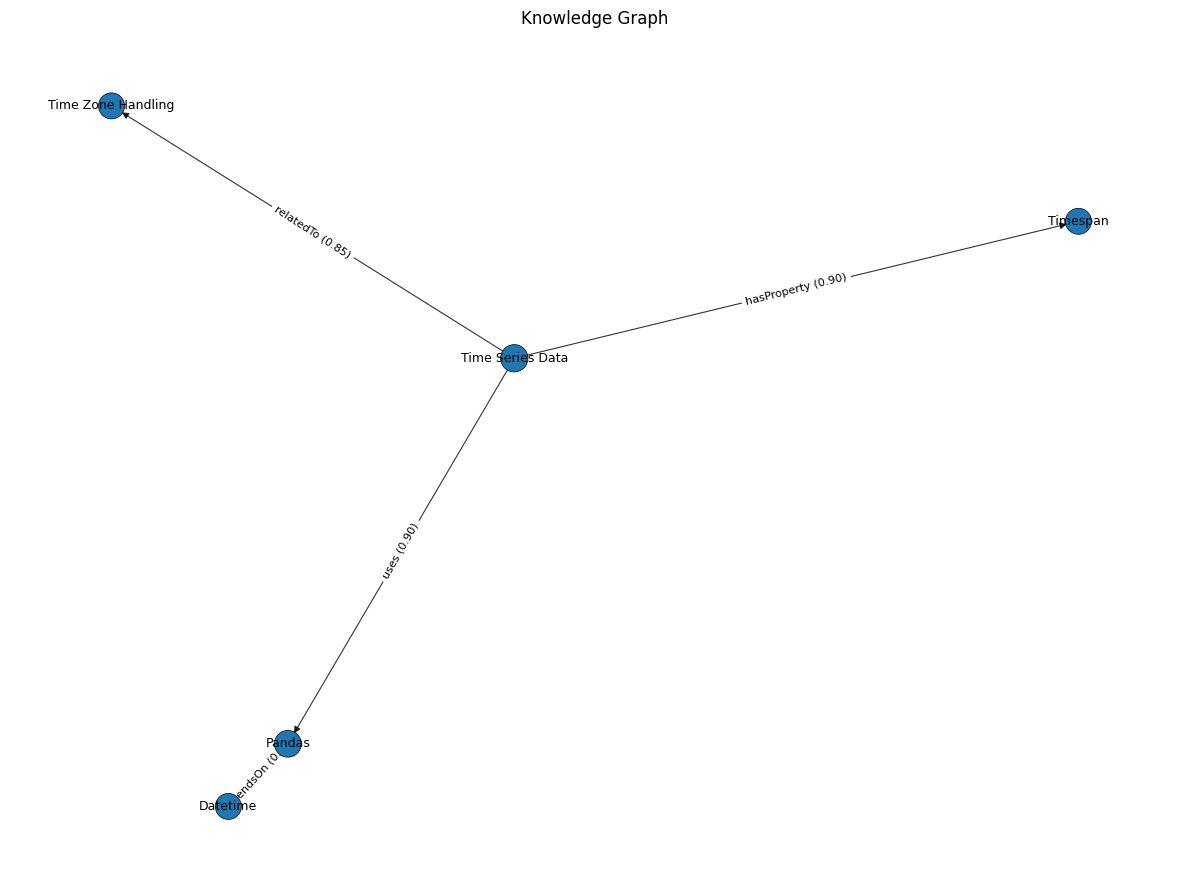

In [23]:
visualize_graph(G, title="Knowledge Graph", max_nodes=120, node_label_attr="label")

In [24]:
len(output_kg_json['nodes']), len(output_kg_json['edges'])

(5, 4)

## Save the Initial KG to File

In [25]:
output_text = json.dumps(output_kg_json, indent=2, ensure_ascii=False)
    
with open(output_kg_json_path, "w", encoding="utf-8") as f:
    f.write(output_text)
    print(f"[OK] Knowledge graph written to {output_kg_json_path}")

[OK] Knowledge graph written to ./data/kg8.json
